## The Puerto Princesa ship

At midnight on a fall day in the Philippines, a ship leaves Puerto Princesa City's seaport to Macao, China. After one or two hours, the boat loses its GPS connection because of a technical issue. Captain keeps navigating the ship to its destination, using the stars and four old radio towers, which you can see on the map. Each antenna could measure the ship's coordinates (X, Y) and send them to its receiver. There are five records of towers signals at five different times, available for you in the records.json file. Also, the boat's actual coordinates are available in the real_coordinates.json file. The exact coordinates are ONLY FOR EVALUATION PURPOSES, and you CAN NOT use them as input data. The five dots on the map below are actual coordinates of the ship, at each time step where the records from antennas were received. Also, the map is decorative and is not part of the data.

![Figure3-1](./Images/map.png)

Each tower has a noise that is coming from a gaussian distribution, meaning that every (X, Y) pair that is received from an antenna is actually derived from:

X = sample_from_normal_distribution(mean = X_real, std = antenna's std)
Y = sample_from_normal_distribution(mean = Y_real, std = antenna's std)

Information of radio towers (coordinate and noise standard deviation) is available in the towers_info.json file.

The ship's movement between those five different time steps could be mathematically modeled as follows:
At each time step, the ship moves D units to the north and F units to either east or west (half of the times west, and half of the times east). D and F are both samples from exponential distributions with a scale of Y_STEP and X_STEP, respectively. Those parameters are available in the moving_model.json file.

### Hidden Markov Model

At this point, you can build a simple HMM and estimate the ship's coordinates using the conditional probabilities that you have. For each time step, calculate the ship's coordinates at that time step and previous time steps, using the tower records received up to that time. In simpler words, calculate:<br>

P(coor_0 | records_0)<br>
P(coor_1 | records_0, records_1)<br>
...<br>
P(coor_4 | records_0, records_1, records_2, records_3, records_4)<br>


The actual coordinates of the ship in the first time step (coor_0) is coming from a 2-dimensional guassian distribution with the mean of Puerto Princesa city's coordinates and covarianve matrix of INIT_COV (scalar) times the identity matrix. INIT_COV and coordinates of Puerto Princesa city is availabel in moving_model.json file.

## Libraries

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json

from scipy.stats import norm, expon
import scipy
import math

## Data

In [ ]:
real_coordinates = json.load(open('./inputs/real_coordinates.json'))
pd.DataFrame(real_coordinates)

,X,Y
0,1087.233417,-57.165368
1,1044.936241,72.343990
2,967.051182,392.826826
3,314.440277,1219.678719
4,590.424895,1413.279887


In [ ]:
towers_info = json.load(open('./inputs/towers_info.json'))
pd.DataFrame(towers_info)

,1,2,3,4
x,1405,10,210,630
y,600,880,1890,2090
std,60,110,90,80


In [ ]:
moving_model = json.load(open('./inputs/moving_model.json'))
moving_model

{'X_STEP': 300,
 'Y_STEP': 600,
 'INIT_COV': 200,
 'Peurto_coordinates': [1105, -50]}

In [ ]:
records = json.load(open('./inputs/records.json'))
pd.DataFrame(records)

,Tower1,Tower2,Tower3,Tower4
0,"[994, -36]","[873, -28]","[958, 70]","[1077, -128]"
1,"[1053, 63]","[926, 26]","[961, 110]","[905, 82]"
2,"[956, 389]","[1106, 499]","[1005, 397]","[901, 326]"
3,"[331, 1227]","[377, 1232]","[270, 1282]","[232, 1051]"
4,"[520, 1376]","[577, 1446]","[397, 1456]","[648, 1364]"


## Functions

In [ ]:
tower_records = [(records.get('Tower1')[i],
                  records.get('Tower2')[i],
                  records.get('Tower3')[i],
                  records.get('Tower4')[i]) for i in range(5)]

In [ ]:
tower_records

[([994, -36], [873, -28], [958, 70], [1077, -128]),
 ([1053, 63], [926, 26], [961, 110], [905, 82]),
 ([956, 389], [1106, 499], [1005, 397], [901, 326]),
 ([331, 1227], [377, 1232], [270, 1282], [232, 1051]),
 ([520, 1376], [577, 1446], [397, 1456], [648, 1364])]

In [ ]:
def get_mean_towers_coor(time_step: int, tower_records: list):
    # The average of all four towers measurements at a given time step
    x = np.average([tower_coor[0] for tower_coor in tower_records[time_step]])
    y = np.average([tower_coor[1] for tower_coor in tower_records[time_step]])
    return x, y

def P_coor0(coor0):
    # Distribuiton of initial coordinates (time step 0)
    x0, y0 = coor0
    return scipy.stats.multivariate_normal.pdf([x0, y0], mean=moving_model.get('Peurto_coordinates'), cov=moving_model.get('INIT_COV')) 

# filling these three functions with apropriate codes: (2 points)

def P_coor_given_prevCoor(coor, prev_coor):
    # Probability of coordinates at time step i, given the coordinates of time step i-1
    x_dev = moving_model['X_STEP']
    y_dev = moving_model['Y_STEP']
    delta_X = abs(coor[0] - prev_coor[0])
    delta_Y = abs(coor[1] - prev_coor[1])
    px = (1/x_dev) * math.exp(-1 * delta_X / x_dev) 
    py = (1/y_dev) * math.exp(-1 * delta_Y / y_dev)
    return px,py
    
def P_towerCoor_given_coor(tower_coor, tower_std, coor):
    # Probability of a tower measurement, given the coordinates of the ship
    # X = sample_from_normal_distribution(mean = X_real, std = antenna's std) 
    # Y = sample_from_normal_distribution(mean = Y_real, std = antenna's std)
    x_std = tower_std
    y_std = tower_std
    delta_X = abs(coor[0] - tower_coor[0])
    delta_Y = abs(coor[1] - tower_coor[1])
    p_x = 1/((2*math.pi)**0.5*x_std) * math.exp(- (delta_X**2)/(2*(x_std**2)))
    p_y = 1/((2*math.pi)**0.5*y_std) * math.exp(- (delta_Y**2)/(2*(y_std**2)))
    return p_x,p_y 
    
def P_record_given_coor(rec, coor, towers_info):
    # All four measurements of all four towers at time step i, is called the record of thime step i.
    # This function returns the probability of a record given the ship's coordinates.
    px = 1
    py = 1
    for i in range(len(rec)):
        num = str(i+1)
        p1,p2 = P_towerCoor_given_coor(rec[i], towers_info[num]['std'], coor)
        px *= p1
        py *= p2
    return px,py


In [ ]:
def real_coor(time_step):
    return round(real_coordinates.get('X')[time_step]), round(real_coordinates.get('Y')[time_step])

def dist(coor_a, coor_b):
    return round(np.sqrt((coor_a[0] - coor_b[0])**2 + (coor_a[1] - coor_b[1])**2))

coor0_estimations = []
coor1_estimations = []
coor2_estimations = []
coor3_estimations = []

#### Estimating coordinates_0 from P(coor_0) and record_0

In the cell below, you can see the approach for finding the argmax of P(coor_0 | record_0), which is equal to argmax of P(record_0 | coor_0) times P(coor_0).
We are not using derivatives to find the argmax, we are actually doing it numerically by trying different coordinates and seeing which one provides the highest probability. <br>

#### Recommended approach: You can use gradient descent to find the argmax of probability function, and that will give you 5 extra points.

In [ ]:
# argmax P(coor_0 | record_0) = argmax P(record_0 | coor_0) P(coor_0)
best_x0, best_y0 = None, None

max_Px, max_Py = 0, 0
interval, step = 20, 5

towers_mean_x0, towers_mean_y0 = get_mean_towers_coor(0, tower_records)

for x0 in range(int(towers_mean_x0 - interval), int(towers_mean_x0 + interval), step):
    for y0 in range(int(towers_mean_y0 - interval), int(towers_mean_y0 + interval), step):
        
        coor0 = (x0, y0)
        rec0 = tower_records[0]

        P_rec0_given_x0, P_rec0_given_y0 = P_record_given_coor(rec0, coor0, towers_info)
        p_c0 = P_coor0(coor0)
    
        Px = P_rec0_given_x0 * p_c0
        Py = P_rec0_given_y0 * p_c0

        if Px > max_Px:
            best_x0 = x0
            max_Px = Px

        if Py > max_Py:
            best_y0 = y0
            max_Py = Py


coor0_estimations.append((best_x0, best_y0))

In [ ]:
print(f'real_coor0: {real_coor(0)} - Estimated_coor0: {best_x0, best_y0}')
print(f'Estimation_error: {dist((best_x0, best_y0), real_coor(0))}')
Loss0 = np.zeros(4)
Loss0[0] = dist((best_x0, best_y0), real_coor(0))

real_coor0: (1087, -57) - Estimated_coor0: (990, -50)
Estimation_error: 97


#### Estimating coordinates_0 and coordinates_1 from P(coor_0), record_0, and record_1<br>

In [ ]:
# argmax P(coor_0 | record_0, record_1)
# argmax P(coor_1 | coor_0, record_0, record_1) 


max_Px, max_Py = 0, 0
interval, step = 20, 5

best_x0, best_y0 = None, None
best_x1, best_y1 = None, None

towers_mean_x1, towers_mean_y1 = get_mean_towers_coor(1, tower_records)

for x0 in range(int(coor0_estimations[-1][0] - interval), int(coor0_estimations[-1][0] + interval), step):
    for y0 in range(int(coor0_estimations[-1][1] - interval), int(coor0_estimations[-1][1] + interval), step):
        
         for x1 in range(int(towers_mean_x1 - interval), int(towers_mean_x1 + interval), step):
            for y1 in range(int(towers_mean_y1 - interval), int(towers_mean_y1 + interval), step):
                    
                coor0 = (x0, y0)
                coor1 = (x1, y1)

                rec0 = tower_records[0]
                rec1 = tower_records[1]
                
                P_rec0_given_x0, P_rec0_given_y0 = P_record_given_coor(rec0, coor0, towers_info)
                p_c0 = P_coor0(coor0)
                p_c1_c0_x,p_c1_c0_y = P_coor_given_prevCoor(coor1,coor0)
                P_rec1_given_x1, P_rec1_given_y1 = P_record_given_coor(rec1, coor1, towers_info)
                
                Px = P_rec0_given_x0 * p_c0 * p_c1_c0_x * P_rec1_given_x1
                Py = P_rec0_given_y0 * p_c0 * p_c1_c0_y * P_rec1_given_y1
                # print(P_rec0_given_x0,p_c0,p_c1_c0_x,P_rec1_given_x1)
                # print(Px,Py)
                
                if Px > max_Px:
                    best_x0 = x0
                    best_x1 = x1
                    max_Px = Px

                if Py > max_Py:
                    best_y0 = y0
                    best_y1 = y1
                    max_Py = Py
            
coor0_estimations.append((best_x0, best_y0))
coor1_estimations.append((best_x1, best_y1))

In [ ]:
print(f'real_coor0: {real_coor(0)} - Estimated_coor0: {best_x0, best_y0}')
print(f'Estimation_error: {dist((best_x0, best_y0), real_coor(0))}')
print()
print(f'real_coor1: {real_coor(1)} - Estimated_coor1: {best_x1, best_y1}')
print(f'Estimation_error: {dist((best_x1, best_y1), real_coor(1))}')
Loss0[1] = dist((best_x0, best_y0), real_coor(0))
Loss1 = np.zeros(3)
Loss1[0] = dist((best_x1, best_y1), real_coor(1))


real_coor0: (1087, -57) - Estimated_coor0: (1005, -50)
Estimation_error: 82

real_coor1: (1045, 72) - Estimated_coor1: (976, 70)
Estimation_error: 69


#### Estimating coordinates_0, coordinates_1 and coordinates_2 from P(coor_0), record_0, record_1, and record_2 <br>

In [ ]:
max_Px, max_Py = 0, 0
interval, step = 20, 5

best_x0, best_y0 = None, None
best_x1, best_y1 = None, None       
best_x2, best_y2 = None, None   

towers_mean_x2, towers_mean_y2 = get_mean_towers_coor(2, tower_records)

for x0 in range(int(coor0_estimations[-1][0] - interval), int(coor0_estimations[-1][0] + interval), step):
    for y0 in range(int(coor0_estimations[-1][1] - interval), int(coor0_estimations[-1][1] + interval), step):
        
         for x1 in range(int(coor1_estimations[-1][0] - interval), int(coor1_estimations[-1][0] + interval), step):
            for y1 in range(int(coor1_estimations[-1][1] - interval), int(coor1_estimations[-1][1] + interval), step):
                
                for x2 in range(int(towers_mean_x2 - interval), int(towers_mean_x2 + interval), step):
                    for y2 in range(int(towers_mean_y2 - interval), int(towers_mean_y2 + interval), step):
                        
                        coor0 = (x0, y0)
                        coor1 = (x1, y1)
                        coor2 = (x2, y2)
                        
                        rec0 = tower_records[0]
                        rec1 = tower_records[1]
                        rec2 = tower_records[2]
                        
                        
                        P_rec0_given_x0, P_rec0_given_y0 = P_record_given_coor(rec0, coor0, towers_info)
                        p_c0 = P_coor0(coor0)
                        p_c1_c0_x,p_c1_c0_y = P_coor_given_prevCoor(coor1,coor0)
                        P_rec1_given_x1, P_rec1_given_y1 = P_record_given_coor(rec1, coor1, towers_info)
                        p_c2_c1_x,p_c2_c1_y = P_coor_given_prevCoor(coor2,coor1)
                        P_rec2_given_x2, P_rec2_given_y2 = P_record_given_coor(rec2, coor2, towers_info)
                        
                        Px = P_rec0_given_x0 * p_c0 * p_c1_c0_x * P_rec1_given_x1 * p_c2_c1_x * P_rec2_given_x2
                        Py = P_rec0_given_y0 * p_c0 * p_c1_c0_y * P_rec1_given_y1 * p_c2_c1_y * P_rec2_given_y2    

                        if Px > max_Px:
                            best_x0 = x0
                            best_x1 = x1
                            best_x2 = x2 
                            max_Px = Px

                        if Py > max_Py:
                            best_y0 = y0
                            best_y1 = y1
                            best_y2 = y2
                            max_Py = Py 

coor0_estimations.append((best_x0, best_y0))
coor1_estimations.append((best_x1, best_y1))
coor2_estimations.append((best_x2, best_y2))

In [ ]:
print(f'real_coor0: {real_coor(0)} - Estimated_coor0: {best_x0, best_y0}')
print(f'Estimation_error: {dist((best_x0, best_y0), real_coor(0))}')
print()
print(f'real_coor1: {real_coor(1)} - Estimated_coor1: {best_x1, best_y1}')
print(f'Estimation_error: {dist((best_x1, best_y1), real_coor(1))}')
print()
print(f'real_coor2: {real_coor(2)} - Estimated_coor2: {best_x2, best_y2}')
print(f'Estimation_error: {dist((best_x2, best_y2), real_coor(2))}')

Loss0[2] = dist((best_x0, best_y0), real_coor(0))
Loss1[1] = dist((best_x1, best_y1), real_coor(1))
Loss2 = np.zeros(2)
Loss2[0] = dist((best_x2, best_y2), real_coor(2))

real_coor0: (1087, -57) - Estimated_coor0: (1020, -50)
Estimation_error: 67

real_coor1: (1045, 72) - Estimated_coor1: (981, 70)
Estimation_error: 64

real_coor2: (967, 393) - Estimated_coor2: (977, 387)
Estimation_error: 12


#### Estimating coordinates_0, coordinates_1, coordinates_2, and coordinates_3 from  P(coor_0), record_0, record_1, record_2, and record_3 <br>

In [ ]:
max_Px, max_Py = 0, 0
interval, step = 25, 5

best_x0, best_y0 = None, None
best_x1, best_y1 = None, None       
best_x2, best_y2 = None, None  
best_x3, best_y3 = None, None

towers_mean_x3, towers_mean_y3 = get_mean_towers_coor(3, tower_records)

for x0 in range(int(coor0_estimations[-1][0] - interval), int(coor0_estimations[-1][0] + interval), step):
    for y0 in range(int(coor0_estimations[-1][1] - interval), int(coor0_estimations[-1][1] + interval), step):
        
         for x1 in range(int(coor1_estimations[-1][0] - interval), int(coor1_estimations[-1][0] + interval), step):
            for y1 in range(int(coor1_estimations[-1][1] - interval), int(coor1_estimations[-1][1] + interval), step):
                
                 for x2 in range(int(coor2_estimations[-1][0] - interval), int(coor2_estimations[-1][0] + interval), step):
                    for y2 in range(int(coor2_estimations[-1][1] - interval), int(coor2_estimations[-1][1] + interval), step): 

                        for x3 in range(int(towers_mean_x3 - interval), int(towers_mean_x3 + interval), step):
                            for y3 in range(int(towers_mean_y3 - interval), int(towers_mean_y3 + interval), step): 
                                
                                coor0 = (x0, y0)
                                coor1 = (x1, y1)
                                coor2 = (x2, y2)
                                coor3 = (x3, y3)

                                rec0 = tower_records[0]
                                rec1 = tower_records[1]
                                rec2 = tower_records[2]
                                rec3 = tower_records[3]
                                
                                P_rec0_given_x0, P_rec0_given_y0 = P_record_given_coor(rec0, coor0, towers_info)
                                p_c0 = P_coor0(coor0)
                                p_c1_c0_x,p_c1_c0_y = P_coor_given_prevCoor(coor1,coor0)
                                P_rec1_given_x1, P_rec1_given_y1 = P_record_given_coor(rec1, coor1, towers_info)
                                p_c2_c1_x,p_c2_c1_y = P_coor_given_prevCoor(coor2,coor1)
                                P_rec2_given_x2, P_rec2_given_y2 = P_record_given_coor(rec2, coor2, towers_info)
                                p_c3_c2_x,p_c3_c2_y = P_coor_given_prevCoor(coor3,coor2)
                                P_rec3_given_x3, P_rec3_given_y3 = P_record_given_coor(rec3, coor3, towers_info)
                                
                                Px = P_rec0_given_x0 * p_c0 * p_c1_c0_x * P_rec1_given_x1 * p_c2_c1_x * P_rec2_given_x2 * p_c3_c2_x * P_rec3_given_x3
                                Py = P_rec0_given_y0 * p_c0 * p_c1_c0_y * P_rec1_given_y1 * p_c2_c1_y * P_rec2_given_y2 * p_c3_c2_y * P_rec3_given_y3  

                                if Px > max_Px:
                                    best_x0 = x0
                                    best_x1 = x1
                                    best_x2 = x2 
                                    best_x3 = x2 
                                    max_Px = Px

                                if Py > max_Py:
                                    best_y0 = y0
                                    best_y1 = y1
                                    best_y2 = y2
                                    best_y3 = y3
                                    max_Py = Py  
                                    
coor0_estimations.append((best_x0, best_y0))
coor1_estimations.append((best_x1, best_y1))
coor2_estimations.append((best_x2, best_y2))
coor3_estimations.append((best_x3, best_y3))

In [ ]:
print(f'real_coor0: {real_coor(0)} - Estimated_coor0: {best_x0, best_y0}')
print(f'Estimation_error: {dist((best_x0, best_y0), real_coor(0))}')
print()
print(f'real_coor1: {real_coor(1)} - Estimated_coor1: {best_x1, best_y1}')
print(f'Estimation_error: {dist((best_x1, best_y1), real_coor(1))}')
print()
print(f'real_coor2: {real_coor(2)} - Estimated_coor2: {best_x2, best_y2}')
print(f'Estimation_error: {dist((best_x2, best_y2), real_coor(2))}')
print()
print(f'real_coor3: {real_coor(3)} - Estimated_coor3: {best_x3, best_y3}')
print(f'Estimation_error: {dist((best_x3, best_y3), real_coor(3))}')

Loss0[3] = dist((best_x0, best_y0), real_coor(0))
Loss1[2] = dist((best_x1, best_y1), real_coor(1))
Loss2[1] = dist((best_x2, best_y2), real_coor(2))

real_coor0: (1087, -57) - Estimated_coor0: (1025, -50)
Estimation_error: 62

real_coor1: (1045, 72) - Estimated_coor1: (981, 70)
Estimation_error: 64

real_coor2: (967, 393) - Estimated_coor2: (972, 387)
Estimation_error: 8

real_coor3: (314, 1220) - Estimated_coor3: (972, 1193)
Estimation_error: 659


As you know from the theoretical aspect, and you can see from your results, the errors of estimations decrease when you use more records and conditional probabilities.

#### Plot curves that show using more records, leads to decrease of estimation error.<br>


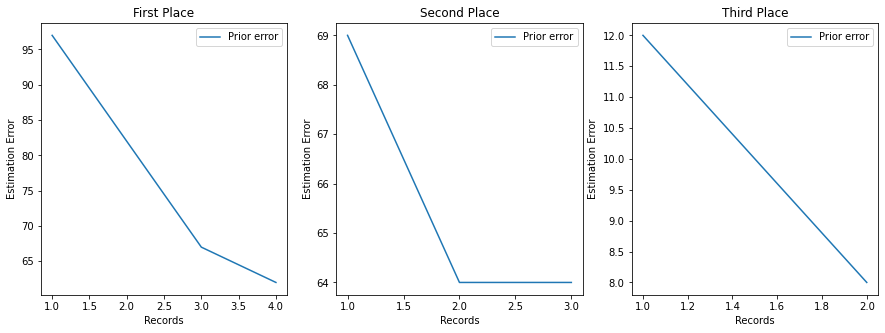

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (15,5))

ax1.plot(range(1,len(Loss0)+1), Loss0, label='Prior error')
ax1.set_xlabel("Records")
ax1.set_ylabel("Estimation Error")
ax1.title.set_text("First Place")
ax1.legend()

ax2.plot(range(1,len(Loss1)+1), Loss1, label='Prior error')
ax2.set_xlabel("Records")
ax2.set_ylabel("Estimation Error")
ax2.title.set_text("Second Place")
ax2.legend()

ax3.plot(range(1,len(Loss2)+1), Loss2, label='Prior error')
ax3.set_xlabel("Records")
ax3.set_ylabel("Estimation Error")
ax3.title.set_text("Third Place")
ax3.legend()